# Introduction

### Problem Description

The problem of [surrogate modelling](https://en.wikipedia.org/wiki/Surrogate_model) is as follows. There are several control variables that can be changed by a decision maker and the goal is to find optimal vector of control variables' values, but a loss to be minimized is hard to measure and so its values are available only on limited amount of control variables' vectors. The approach of surrogate modelling lies in building a model that approximates the loss function on the whole set of available inputs and is based on available data. Then a minimum point of loss function's approximation is regarded as minimum point of real loss.

Let us provide an example of situation where surrogate modelling is appropriate. Suppose that engineers are going to create new alloy of two metals and these engineers have two control variables: proportion of one metal to the other and intensity of heat treatment. Assume also that a loss is fragility of alloy. Engineers can produce pieces of various alloys that are obtained with several values of control variables and test them empirically, but this procedure is expensive. After some data are gathered, it is possible to build an approximation of fragility function and then test an alloy that corresponds to its minimum point.

In this notebook, machine learning approach is used for surrogate modelling of some functions of two variables. Note that usage of tree-based ensembles is not interesting in this context, because they can not make a prediction that is below target's minimum over training sample or above target's maximum over training sample and, in particular, they can not extrapolate trends. Neural networks are a more intriguing choice.

### Software Requirements

This notebook does not use any packages beyond a list of those that are quite popular in scientific computing. Use conda or pip to install any of them.

# General Preparations

In [1]:
from functools import partial

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import keras
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [2]:
np.random.seed(361)

# Template of Experiments

### Designs of Experiments

Since functions of just two arguments are studied here, there is no curse of dimensionality. Hence, complex designs such as [Latin hypercubes](https://en.wikipedia.org/wiki/Latin_hypercube_sampling), [Sobol sequences](https://en.wikipedia.org/wiki/Sobol_sequence), or [Halton sequences](https://en.wikipedia.org/wiki/Halton_sequence) are not necessary. Only two designs are used:
* Random sampling from uniform distribution on a constrained segment of domain;
* Grid of particular size and equal steps. 

In [3]:
def draw_from_uniform_distribution(n_samples, x_borders, y_borders):
    """
    Draws `n_samples` from a uniform
    distribution on a rectangle that is
    a Cartesian product of intervals with
    ends represented by `x_borders` and
    `y_borders` respectively.
    
    @type n_samples: int
    @type x_borders: tuple(float)
    @type y_borders: tuple(float)
    @rtype: numpy.ndarray
    """
    xs = np.random.uniform(x_borders[0], x_borders[1], n_samples).reshape((-1, 1))
    ys = np.random.uniform(y_borders[0], y_borders[1], n_samples).reshape((-1, 1))
    return np.hstack((xs, ys))

In [4]:
def create_grid(step, left_bottom_corner, x_n_steps, y_n_steps):
    """
    Returns array of points from a rectangular
    grid with `step` as vertical or horizontal
    distance between adjacent nodes. Size of
    grid is determined by `x_n_steps` and
    `y_n_steps`, while its location is determined
    via `left_bottom_corner`.
    
    @type step: float
    @type left_bottom_corner: tuple(float)
    @type x_n_steps: int
    @type y_n_steps: int
    @rtype: numpy.ndarray
    """
    xs = [left_bottom_corner[0] + i * step for i in range(x_n_steps)]
    ys = [left_bottom_corner[1] + i * step for i in range(y_n_steps)]
    return np.transpose([np.tile(xs, len(ys)), np.repeat(ys, len(xs))])

Actually, brute force over points from above designs is used for surrogate loss optimization. More complex techniques (e.g. gradient-based optimization or [Nelder-Mead method](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method)) are not used, because brute force is computationally feasible due to low dimensionality.

### Runner

In [42]:
class RunnerOfSurrogateModelling(object):
    """
    Structurizes utilities that are useful
    for the following experiment. Given a
    function of two real-valued arguments
    `func` (actually, `func` must have also
    an optional argument `noise_stddev`),
    learning sample for this function recovery
    is drawn from an experiment that is
    designed in accordance with `measurement_doe`.
    Then a neural network returned by
    `build_model` is trained to approximate `func`
    and its optimum is found in accordance
    with `optimization_doe`.
    """
    
    def __init__(self, func, noise_stddev, build_model,
                 measurement_doe, optimization_doe):
        """
        @type func: function
        @type noise_stddev: float
        @type build_model: function
        @type measurement_doe: str
        @type optimization_doe: str
        """
        self.func = func
        self.build_model = build_model
        
        if measurement_doe == 'random':
            self.draw_measurements = draw_from_uniform_distribution
        elif measurement_doe == 'grid':
            self.draw_measurements = create_grid
        else:
            raise ValueError("Unknown `measurement_doe`: {}".format(measurement_doe))
            
        if optimization_doe == 'random':
            self.draw_candidates = draw_from_uniform_distribution
        elif optimization_doe == 'grid':
            self.draw_candidates = create_grid
        else:
            raise ValueError("Unknown `optimization_doe`: {}".format(optimization_doe))
        
        self.train_data = None
        self.model = None
        self.goodness_of_fit = None
        self.minimum_point = None
        self.actual_value_at_minimum_point = None
        self.benchmark = None
        
    def _draw_train_data(self, **kwargs):
        """
        Draws data according to design of
        experiment specified by `kwargs` and
        `self.draw_measurements`.
        
        @rtype: NoneType
        """
        train_inputs = self.draw_measurements(**kwargs)
        self.train_data = pd.DataFrame(train_inputs, columns=['x', 'y'])
        self.train_data['target'] = self.train_data.apply(
            lambda row: self.func(row['x'], row['y'], noise_stddev), axis=1)
        
    def _train_surrogate_model(self, **kwargs):
        """
        Fits `self.model` to `self.train_data`
        with specified hyperparameters.
        
        @rtype: NoneType
        """
        # In Keras, there is no easy way to reset weights without recompiling a model.
        self.model = self.build_model()
        X_train, X_test, y_train, y_test = \
            train_test_split(self.train_data[['x', 'y']].as_matrix(),
                             self.train_data['target'].as_matrix(),
                             random_state=361)
        hst = self.model.fit(X_train, y_train, validation_data=(X_test, y_test),
                             callbacks=[keras.callbacks.History()], verbose=0, **kwargs)
        self.goodness_of_fit = {'train_mse': hst.history['loss'][-1],
                                'val_mse': hst.history['val_loss'][-1]}
        
    def _compare_target_vs_surrogate(self, **kwargs):
        """
        Plots two graphs near each other
        and computes R^2 coefficient of
        determination.
        
        @rtype: NoneType
        """
        df = pd.DataFrame(create_grid(**kwargs), columns=['x', 'y'])
        df['target'] = df.apply(
            lambda row: self.func(row['x'], row['y'], noise_stddev=0),
            axis=1)
        df['surrogate'] = df.apply(
            lambda row: self.model.predict(row[['x', 'y']].as_matrix().reshape((1, 2)))[0, 0],
            axis=1)
        self.goodness_of_fit['r2'] = r2_score(df['target'], df['surrogate'])
        print("    Evaluation: overall R^2 is {:1.3f}".format(self.goodness_of_fit['r2']))
        
        fig = plt.figure(figsize=(15, 7))
        
        ax_one = fig.add_subplot(121)
        ax_one.scatter(df['x'], df['y'], c=df['target'], cmap='coolwarm')
        ax_one.set_title('Actual function')
        ax_one.set_xlabel('x')
        ax_one.set_ylabel('y')
        ax_one.set_aspect('equal')
        
        # TODO: unify colormap scale.
        ax_two = fig.add_subplot(122)
        ax_two.scatter(df['x'], df['y'], c=df['surrogate'], cmap='coolwarm')
        ax_two.set_title('Surrogate function')
        ax_two.set_xlabel('x')
        ax_two.set_ylabel('y')
        ax_two.set_aspect('equal')
        
    def _compute_benchmark(self):
        """
        Computes benchmark that is a score at
        a minimum point of (in general, noisy)
        measured target. Ties in values of the
        measured target are broken at random.
        
        @rtype: NoneType
        """
        cond = self.train_data['target'] == self.train_data['target'].min()
        potential_inputs = self.train_data.loc[cond, ['x', 'y']]
        inputs = potential_inputs.sample(random_state=361).iloc[0, :]
        self.benchmark = self.func(inputs['x'], inputs['y'], noise_stddev=0)
    
    def _find_minimum_of_surrogate_target(self, **kwargs):
        """
        Finds a point with the lowest prediction
        of `self.model` amongst points that are
        obtained in accordance with
        `self.optimization_doe`.
        Ties are broken by random choice.
        
        @rtype: NoneType
        """
        candidates = self.draw_candidates(**kwargs)
        candidates = pd.DataFrame(candidates, columns=['x', 'y'])
        candidates['surrogate_target'] = candidates.apply(
            lambda row: self.model.predict(row.as_matrix().reshape((1, 2)))[0, 0],
            axis=1)
        
        cond = candidates['surrogate_target'] == candidates['surrogate_target'].min()
        minimum_points = candidates.loc[cond, ['x', 'y']]
        self.minimum_point = minimum_points.sample(random_state=361).iloc[0, :]
        self.minimum_point = self.minimum_point.as_matrix().reshape((1, 2))
        self.actual_value_at_minimum_point = self.func(
            self.minimum_point[0, 0], self.minimum_point[0, 1], noise_stddev=0)
        
    def run_experiment(self, n_runs, runs_to_be_evaluated, evaluation_settings,
                       measurement_settings, train_settings, optimization_settings,
                       same_train_sample_for_all_runs=True, verbose=True):
        """
        Launchs `n_runs` experiments defined by
        `measurement_settings`, `train_settings`,
        and `optimization_settings`.
        For experiments that are in
        `runs_to_be_evaluated`, learnt surrogate
        function is plotted against the actual
        function with 'evaluation_settings`
        and R^2 score is computed. To avoid
        granularity of graphs, one should pass
        fine grid and it makes computations
        hard, so it is recommended to include
        only small proportion of runs.
        
        @type n_runs: int
        @type runs_to_be_evaluated: list(int)
        @type evaluation_settings: dict(str -> any)
        @type measurement_settings: dict(str -> any)
        @type train_settings: dict(str -> any)
        @type optimization_settings: dict(str -> any)
        @type same_train_sample_for_all_runs: bool
        @type verbose: bool
        @rtype: pandas.DataFrame
        """
        results = []
        for i in range(n_runs):
            if verbose:
                print('Run # {} is started.'.format(i))
            if self.train_data is None:
                self._draw_train_data(**measurement_settings)
            
            # Even if `same_train_sample_for_all_runs` is `True`,
            # benchmark can vary due to ties.
            self._compute_benchmark()
            
            self._train_surrogate_model(**train_settings)
            if i in runs_to_be_evaluated:
                self._compare_target_vs_surrogate(**evaluation_settings)
            self._find_minimum_of_surrogate_target(**optimization_settings)
            
            benchmark = self.benchmark
            score = self.actual_value_at_minimum_point
            minimum_point_x = self.minimum_point[0, 0]
            minimum_point_y = self.minimum_point[0, 1]
            results.append([benchmark, score, minimum_point_x, minimum_point_y])
            
            if not same_train_sample_for_all_runs:
                self.train_data = None
        result = pd.DataFrame(results, columns=['benchmark', 'score', 'x', 'y'])
        return result

In [6]:
def build_mlp(hidden_layers_widths, keep_prob, learning_rate):
    """
    Builds Multi-Layer Perceptron (MLP).
    
    @type hidden_layers_widths: list(int)
    @type keep_prob: float
    @type learning_rate: float
    @rtype: keras.Model
    """
    model = keras.models.Sequential()
    model.add(Dense(hidden_layers_widths[0], input_dim=2,
                    init='normal', activation=LeakyReLU(alpha=0.01)))
    model.add(Dropout(keep_prob))
    for i in range(1, len(hidden_layers_widths)):
        model.add(Dense(hidden_layers_widths[i],
                        init='normal', activation=LeakyReLU(alpha=0.01)))
        model.add(Dropout(keep_prob))
    model.add(Dense(1, init='normal'))
    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(lr=learning_rate))
    return model

# Experiments

### Himmelblau's Function

As an example of non-convex function with multiple global minima, [Himmelblau's function](https://en.wikipedia.org/wiki/Himmelblau%27s_function) is chosen here.

It is: $$f(x, y) = (x^2+y-11)^2 + (x+y^2-7)^2.$$

Himmelblau's function is of particular interest, because there is a region where it looks like plateau.

In [7]:
def noisy_himmelblaus_function(x, y, noise_stddev=0):
    """
    Computes Himmelblau's function at
    point (`x`, `y`) and adds some
    Gaussian noise.
    
    @type x: float
    @type y: float
    @type noise_stddev: float
    @rtype: float
    """
    himmelblaus_value = (x**2 + y - 11)**2 + (x + y**2 - 7)**2
    noise = np.random.normal(scale=noise_stddev, size=1)[0]
    return himmelblaus_value + noise

In [ ]:
# Target definition.
func = noisy_himmelblaus_function
noise_stddev = 0.01

# Model settings.
hidden_layers_widths = [100, 50]
keep_prob = 0.95
learning_rate = 0.001
train_settings = {'epochs': 100,
                  'batch_size': 16}

# Design of experiment.
measurement_doe = 'random'
measurement_settings = {'n_samples': 20000,
                       'x_borders': (-7, 7),
                       'y_borders': (-7, 7)}
optimization_doe = 'grid'
optimization_settings = {'step': 0.1,
                         'left_bottom_corner': (-7, -7),
                         'x_n_steps': 141,
                         'y_n_steps': 141}

Run # 0 is started.
Run # 1 is started.
Run # 2 is started.
Run # 3 is started.
Run # 4 is started.
Run # 5 is started.
Run # 6 is started.
Run # 7 is started.
Run # 8 is started.
Run # 9 is started.


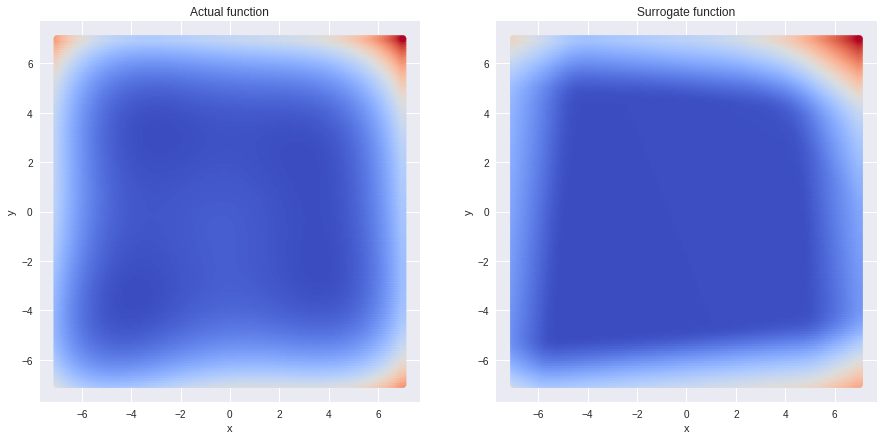

In [9]:
build_model = partial(build_mlp, *[hidden_layers_widths, keep_prob, learning_rate])
runner = RunnerOfSurrogateModelling(
    func, noise_stddev, build_model, measurement_doe, optimization_doe)
df = runner.run_experiment(n_runs=10, runs_to_be_evaluated=[0],
                           evaluation_settings=optimization_settings,
                           measurement_settings=measurement_settings,
                           train_settings=train_settings,
                           optimization_settings=optimization_settings)

Surrogate function has low variance within a region that is coloured in deep blue on the right graph. Does it result in wrong placement of minimum points? 

In [10]:
df[['benchmark', 'score']].describe()

,benchmark,score
count,1.000000e+01,10.000000
mean,5.799082e-03,180.555200
std,9.142795e-19,33.743528
min,5.799082e-03,136.210100
25%,5.799082e-03,159.718550
50%,5.799082e-03,172.578900
75%,5.799082e-03,190.702300
max,5.799082e-03,243.843200


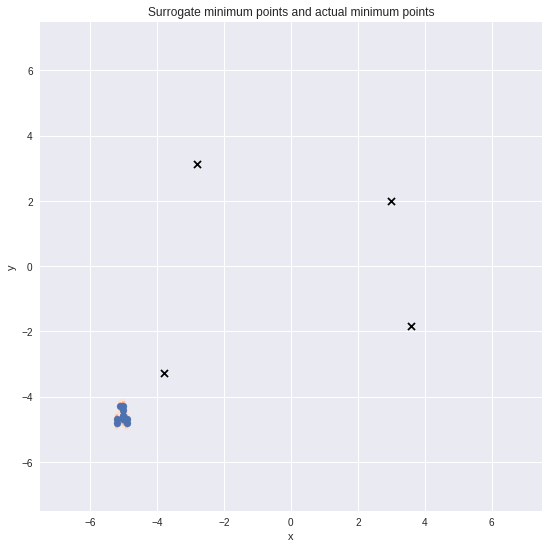

In [11]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
ax.set_xlim(-7.5, 7.5)
ax.set_ylim(-7.5, 7.5)
ax.set_title('Surrogate minimum points and actual minimum points')
ax.set_xlabel('x')
ax.set_ylabel('y')

sns.kdeplot(df['x'], df['y'], cmap='Reds', shade=True, shade_lowest=False, ax=ax)
ax.scatter(df['x'], df['y'])

himmelblaus_roots = pd.DataFrame([[3, 2],
                                  [-2.805118, 3.131312],
                                  [-3.77931, -3.283186],
                                  [3.584428, -1.848126]],
                                  columns=['x', 'y'])
_ = ax.scatter(himmelblaus_roots['x'], himmelblaus_roots['y'], marker='x', s=50, c='black')

Surrogate minimum points (blue points) are far enough from the nearest to them actual minimum point (represented as a black cross).

### Rosenbrock Function

Now let us try another nonconvex function. Namely, it is [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function).

Its definition is: $$f(x, y) = (a - x)^2 + b(y - x^2)^2.$$

Rosenbrock function is of particular interest, because it has a valley where its values are close to its global minimum.

In [7]:
def noisy_rosenbrock_function(x, y, noise_stddev=0, a=1, b=100):
    """
    Computes Rosenbrock function
    with parameters `a` and `b`at
    point (`x`, `y`) and adds some
    Gaussian noise.
    
    @type x: float
    @type y: float
    @type noise_stddev: float
    @type a: float
    @type b: float
    @rtype: float
    """
    rosenbrock_value = (a - x)**2 + b * (y - x**2)**2
    noise = np.random.normal(scale=noise_stddev, size=1)[0]
    return rosenbrock_value + noise

In [43]:
# Target definition.
func = noisy_rosenbrock_function
noise_stddev = 0.01

# Model settings.
hidden_layers_widths = [200, 100]
keep_prob = 0.95
learning_rate = 0.001
train_settings = {'epochs': 100,
                  'batch_size': 16}

# Design of experiment.
measurement_doe = 'random'
measurement_settings = {'n_samples': 20000,
                       'x_borders': (-2, 2),
                       'y_borders': (-1, 3)}
optimization_doe = 'grid'
optimization_settings = {'step': 0.05,
                         'left_bottom_corner': (-2, -1),
                         'x_n_steps': 81,
                         'y_n_steps': 81}

# Making plots less granular.
evaluation_settings = {'step': 0.025,
                          'left_bottom_corner': (-2, -1),
                          'x_n_steps': 161,
                          'y_n_steps': 161}

Run # 0 is started.
    Evaluation: overall R^2 is 0.7072387560235727
Run # 1 is started.
Run # 2 is started.


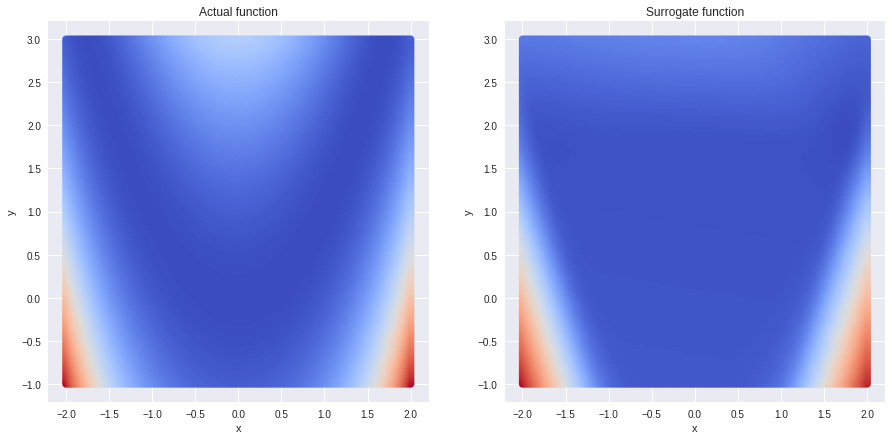

In [44]:
build_model = partial(build_mlp, *[hidden_layers_widths, keep_prob, learning_rate])
runner = RunnerOfSurrogateModelling(
    func, noise_stddev, build_model, measurement_doe, optimization_doe)
df = runner.run_experiment(n_runs=10, runs_to_be_evaluated=[0],
                           evaluation_settings=evaluation_settings,
                           measurement_settings=measurement_settings,
                           train_settings=train_settings,
                           optimization_settings=optimization_settings)

In [45]:
df[['benchmark', 'score']].describe()

,benchmark,score
count,3.000000,3.000000
mean,0.003691,111.633333
std,0.000000,17.664961
min,0.003691,95.650000
25%,0.003691,102.150000
50%,0.003691,108.650000
75%,0.003691,119.625000
max,0.003691,130.600000


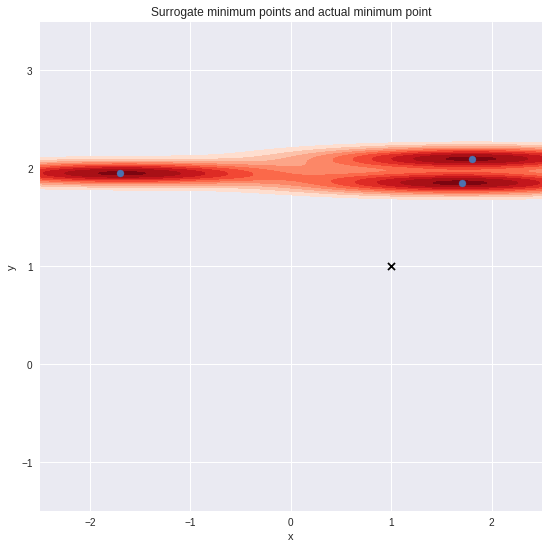

In [46]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-1.5, 3.5)
ax.set_title('Surrogate minimum points and actual minimum point')
ax.set_xlabel('x')
ax.set_ylabel('y')

sns.kdeplot(df['x'], df['y'], cmap='Reds', shade=True, shade_lowest=False, ax=ax)
ax.scatter(df['x'], df['y'])

rosenbrock_roots = pd.DataFrame([[1, 1]],
                                 columns=['x', 'y'])
_ = ax.scatter(rosenbrock_roots['x'], rosenbrock_roots['y'], marker='x', s=50, c='black')

It looks like surrogate minimum points are less stable than in case of Himmelblau's function's modeliing, does it?

# Conclusion

One might think that surrogate modelling does not give any advantages over naive approach at least in 2D case. Although surrogate modelling is an approach suitable for high-dimensional data where grids' sizes grow too fast to allow having fine enough steps, there is an obvious improvement of surrogate modelling's scores. Himmelblau's function is a polynom and Rosenbrock function is a polynom as well. Thus, linear regression with squared terms included can model these functions better than the neural networks that are trained above. If you are wondering why neural networks are chosen here as a tool, please note that this notebook is placed in a directory named `hard_use_and_abuse`.

The last, but not the least, all above experiments are run with quite low standard deviation of noise. An interested reader can increase this parameter and look how performances of both benchmarks and surrogate models degrade.